# Esercitazione 3: libreria pandas, classificazione e regressione con algoritmi Naive-Bayes e k-NN con la libreria scikit-learn


**Task:** implementare algoritmi di classificazione e regressione basati su stima delle densità di probabilità (Naive-Bayes e k-NN) per l'identificazione di sub-strutture in Jet adronici in eventi prodotti al colissore adronico LHC del CERN

Referenza: [https://arxiv.org/abs/1603.09349](https://arxiv.org/abs/1603.09349)https://arxiv.org/abs/1603.09349

**Operazioni preliminari: download del dataset ...**

NOTA: dataset esteso, 231MB compresso, tipicamente richiede un 2-5 minuti per essere scaricato

In [1]:
!rm -rf JetSubStruct.dat
!rm -rf JetSubStruct.dat.gz
!wget http://giagu.web.cern.ch/giagu/CERN/JetSubStruct.dat.gz
!gunzip JetSubStruct.dat.gz

--2025-03-02 14:38:05--  http://giagu.web.cern.ch/giagu/CERN/JetSubStruct.dat.gz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.18.46, 137.138.124.182, 188.185.5.88, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.18.46|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/JetSubStruct.dat.gz [following]
--2025-03-02 14:38:05--  https://giagu.web.cern.ch/giagu/CERN/JetSubStruct.dat.gz
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.18.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242587110 (231M) [application/x-gzip]
Saving to: ‘JetSubStruct.dat.gz’

JetSubStruct.dat.gz 100%[===================>] 231.35M  21.8MB/s    in 11s     

2025-03-02 14:38:17 (20.9 MB/s) - ‘JetSubStruct.dat.gz’ saved [242587110/242587110]



**Parte 1: Importazione del dataset in un dataframe pandas e analisi statistica e visuale del dataset stesso**

Il dataset è costituito da 10M di eventi appartenenti a due processi fisici prodotti nelle interazioni protone-protone a LHC:

* QCD di-jet production $q\bar{q} \to jet\,jet$ (**classe fondo**)
* EW boosted $W$ decays in di-jet $W \to  \to qq' \to jet\,jet$ (**classe segnale**)

Gli stati finali visibili nel rivelatore (getti adronici ($jet$)) sono molto simili nei due processi, ma nel caso dei decadimenti del $W$ a causa dell'alto boost di lorentz i due jet tendono a sovrapporsi in un singolo jet detto "merged" o "fat jet". La presenza dei due jet sovrapposti crea delle sotto-strutture peculiari all'interno del deposito di energia del jet che possono essere utilizzate per discriminare i "merged" jet dai jet di QCD.

Ogni evnto del dataset rappresenta un jet, descritto da 6 osservabili fisiche di alto livello (feature) e da una label $1,0$ che indica se l'evento è di classe segnale o di classe fondo.

Le osservabili di alto livello sono:

*   $Mjet$: massa invariante del Jet
*   $C21, C21, D21, D22$: 4 funzioni di correlazione energetica tra i sotto-elementi del jet
*   $Tau21$: 21-subjetiness (una misura di quanto il jet è composto da 2 vs 1-subjet), tende a $1$ per jet composti da un solo jet e a 0 per jet composti da due jet

I dati sono contenuti nel file *JetSubStruct.dat*, che è un file *.csv* in cui ogni riga contiene le 6 osservabili + la label del evvento.

**NOTA: Gli algoritmi come Naive Bayes e sopratutto k-NN possono diventare molto lenti al crescere della dimensione del campione di training, conviene quindi leggere solo una parte del dataset (10k eventi) per non rendere troppo lenti gli algoritmi**


**compiti:**
1.   importare il file in un dataframe pandas

```
df = pd.read_csv(nomefile, nrows=10000) #importa le prime nrows righe (eventi) dal file
```

2.   produrre la statistica descrittiva del dataset: valori medi, varianze, e matrice di correlazione per le 6 osservabili (non usare la label). Per farlo sfruttare i metodi di pandas applicabili ad un dataframe df: *df.describe()* e *df.corr()*

3.   graficare gli istogrammi delle 6 osservabili con in rosso gi eventi della classe segnale (W) e in blu gli eventi della classe fondo (QCD)


```
# si può selezionare una variabile (colonna) specifica del dataframe nel seguente modo:

# lista contenente i nomi associati alle variabili di ogni colonna
colonne = list(df.columns)
print(colonne)


df['C21'] #seleziona la colonna contenete la feature C21 (oppure df[colonne[1]]

# si possono selezionare righe applicando condizioni sulle colonne
# esempio: seleziono solo gli eventi con Label = 1 (segnale):

dfS = df.loc[df['Label']>0.5] #dfS è un nuovo dataset contenenete solo le righe in cui il valore della Label è maggiore di 0.5 (eventi segnale)

```


4.   graficare i plot di correlazione tra le coppie di osservabili per le due classi

```
#suggerimento: usare la funzione pandas *scatter_matrix*
from pandas.plotting import scatter_matrix
```


In [7]:
import pandas as pd
df = pd.read_csv('JetSubStruct.dat', nrows=10000)
print(f'Colonne nel dataset: {df.columns}')
display(df.head(3))
display(df.tail(3))

Colonne nel dataset: Index(['Mjet', 'C21', 'C22', 'D21', 'D22', 'Tau12', 'Label'], dtype='object')


,Mjet,C21,C22,D21,D22,Tau12,Label
0,83.1238,0.056322,0.007502,0.431626,0.122363,0.083797,1.0
1,114.0480,0.092756,0.016106,0.705808,0.146008,0.126179,0.0
2,40.1448,0.069905,0.009982,0.999098,0.572507,0.312938,0.0


,Mjet,C21,C22,D21,D22,Tau12,Label
9997,78.0869,0.079938,0.014323,0.605183,0.236965,0.194843,1.0
9998,14.6587,0.069615,0.014715,5.595860,9.113180,0.595198,0.0
9999,100.0590,0.034953,0.005903,0.255985,0.082798,0.037685,1.0


In [8]:
# statistica descrittiva
col = df.columns[:-1]
display(df[col].describe())
display(df[col].corr())

,Mjet,C21,C22,D21,D22,Tau12
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,64.119075,0.116967,0.044424,1.999058,2.319157,0.326521
std,35.144152,0.074923,0.062884,3.744427,6.453384,0.179834
min,-0.000075,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.128550,0.066007,0.012932,0.879955,0.440453,0.186419
50%,68.862650,0.104987,0.025958,1.298620,1.004905,0.317954
75%,83.737700,0.153304,0.048320,2.016447,2.180223,0.464292
max,248.591000,0.577043,0.880201,149.987000,279.142000,0.857832


,Mjet,C21,C22,D21,D22,Tau12
Mjet,1.000000,0.639681,0.488897,-0.291517,-0.298242,0.019445
C21,0.639681,1.000000,0.863157,-0.032757,-0.062227,0.629523
C22,0.488897,0.863157,1.000000,-0.004772,-0.000450,0.463774
D21,-0.291517,-0.032757,-0.004772,1.000000,0.918022,0.194251
D22,-0.298242,-0.062227,-0.000450,0.918022,1.000000,0.171074
Tau12,0.019445,0.629523,0.463774,0.194251,0.171074,1.000000


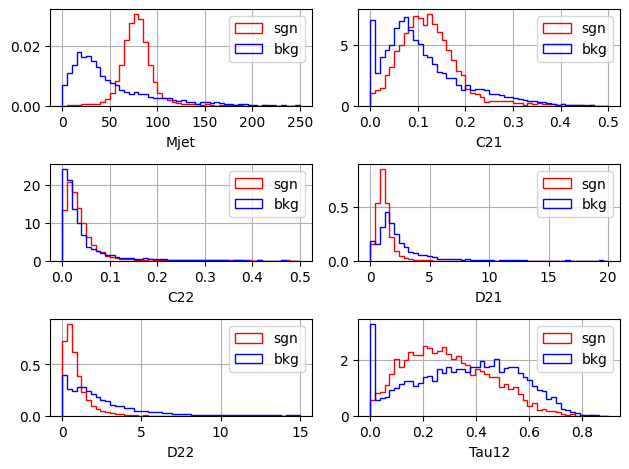

In [5]:
import matplotlib.pyplot as plt

filtro = (df['Label']==1.0)
signal = df[filtro]
bkg = df[-filtro]
bins = [[0,250], [0,0.5], [0,0.5], [0, 20], [0,15], [0,0.9]]

for i in range(6):
  plt.subplot(3,2,i+1)
  plt.hist(signal[col[i]], density=True, color='r', histtype='step', bins=50, range=bins[i], label='sgn')
  plt.hist(bkg[col[i]], density=True, color='b', histtype='step', bins=50, range=bins[i], label='bkg')
  plt.xlabel(col[i])
  plt.legend()
  plt.grid()
plt.tight_layout()

array([[<Axes: xlabel='Mjet', ylabel='Mjet'>,
        <Axes: xlabel='C21', ylabel='Mjet'>,
        <Axes: xlabel='C22', ylabel='Mjet'>,
        <Axes: xlabel='D21', ylabel='Mjet'>,
        <Axes: xlabel='D22', ylabel='Mjet'>,
        <Axes: xlabel='Tau12', ylabel='Mjet'>],
       [<Axes: xlabel='Mjet', ylabel='C21'>,
        <Axes: xlabel='C21', ylabel='C21'>,
        <Axes: xlabel='C22', ylabel='C21'>,
        <Axes: xlabel='D21', ylabel='C21'>,
        <Axes: xlabel='D22', ylabel='C21'>,
        <Axes: xlabel='Tau12', ylabel='C21'>],
       [<Axes: xlabel='Mjet', ylabel='C22'>,
        <Axes: xlabel='C21', ylabel='C22'>,
        <Axes: xlabel='C22', ylabel='C22'>,
        <Axes: xlabel='D21', ylabel='C22'>,
        <Axes: xlabel='D22', ylabel='C22'>,
        <Axes: xlabel='Tau12', ylabel='C22'>],
       [<Axes: xlabel='Mjet', ylabel='D21'>,
        <Axes: xlabel='C21', ylabel='D21'>,
        <Axes: xlabel='C22', ylabel='D21'>,
        <Axes: xlabel='D21', ylabel='D21'>,
        <Axes

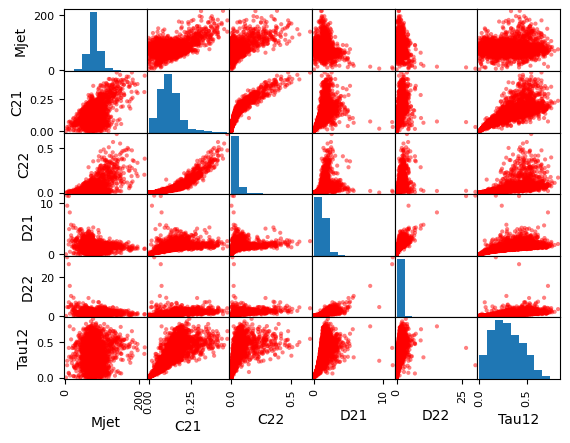

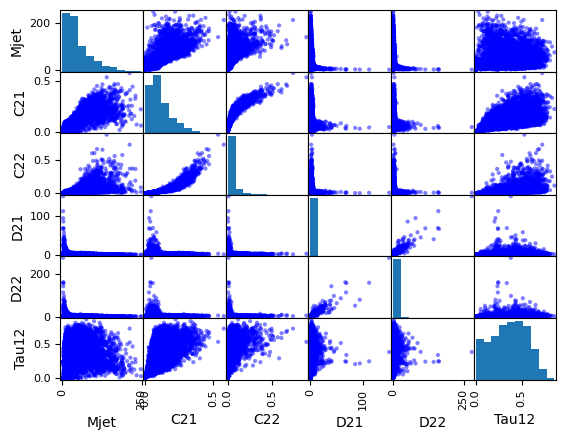

In [6]:
from pandas.plotting import scatter_matrix
scatter_matrix(signal[col], color='red')
scatter_matrix(bkg[col], color='b')

**Parte 2: pre-processing delle feature**

1.   partizionamento (splitting) del campione in due sottocampioni: training e test (80%, 20%)


```
# suggerimento: usate lo slicing dei vettori numpy che funziona anche su i dataframe di pandas

part_df = df[:1000].copy()  #crea un nuovo dataframe contenente le prime 1000 righe di df

#NOTA: le operazioni di slicing non resettano l'indice di colonna, per farlo:

part_df = part_df.reset_index(drop=True)

```


2.   normalizzare tutte le feature in modo che abbiano media zero e varianza 1

`SUGGERIMENTO: è possibile usare le funzioni *df.mean()* e *df.std()* di pandas e notare che quando applicate ad un dataframe sono applicate column-wise (cioè separatamente per ciascuna colonna)`

NOTA: i parametri per la normalizzazione delle feature vanno ottenuti con il solo campione di training in modo da evitare propagazione di informazione dal campione di training nel campione di test (*information leaks nel test set*).

Il test set deve fare le veci di un campione di eventi distribuito come quello ustilizzato nel training ma mai osservato in precedenza, da utilizzare unicamente per la misura delle prestazioni finali del modello di ML addestrato, va quindi normalizzato rispetto ai parametri misurati dal solo training set.


In [25]:
from sklearn.model_selection import train_test_split
train_to_test_ratio = 0.20
x_train, x_test, y_train, y_test = train_test_split(df[col], df['Label'], test_size=train_to_test_ratio, random_state=123, shuffle=True)

# normalizzazione
train_mean = df[col].mean()
train_std = df[col].std()
X_train = (x_train-train_mean)/train_std
X_test = (x_test-train_mean)/train_std

print(f'Splitting train/test: {X_train.shape}/{X_test.shape}')

# Check
print(f'\n train set prima della normalizzazione:')
display(x_train.describe().iloc[1:3, :])
print(f'\n test set prima della normalizzazione:')
display(x_test.describe().iloc[1:3, :])

print(f'\n train set dopo la normalizzazione:')
display(X_train.describe().iloc[1:3, :])
print(f'\n test set dopo la normalizzazione:')
display(X_test.describe().iloc[1:3, :])

Splitting train/test: (8000, 6)/(2000, 6)

 train set prima della normalizzazione:


,Mjet,C21,C22,D21,D22,Tau12
mean,64.011893,0.116930,0.044310,2.022199,2.365757,0.326413
std,35.139455,0.074676,0.062457,3.866767,6.793076,0.179260



 test set prima della normalizzazione:


,Mjet,C21,C22,D21,D22,Tau12
mean,64.547801,0.117116,0.044879,1.906492,2.132755,0.326952
std,35.168458,0.075924,0.064575,3.207963,4.859824,0.182154



 train set dopo la normalizzazione:


,Mjet,C21,C22,D21,D22,Tau12
mean,-0.003050,-0.000498,-0.001808,0.006180,0.007221,-0.000599
std,0.999866,0.996697,0.993218,1.032672,1.052638,0.996812



 test set dopo la normalizzazione:


,Mjet,C21,C22,D21,D22,Tau12
mean,0.012199,0.001991,0.007232,-0.024721,-0.028884,0.002397
std,1.000692,1.013355,1.026902,0.856730,0.753066,1.012902


**Parte 3: Costruzione e addestramento di un classificatire Naive-Bayes e un classificatore k-NN**

1.   addestrare due modelli scikit-learn: uno di tipo *sklearn.naive_bayes NBGaussian*, e uno di tipo *neighbors.KNeighborsClassifier*, confrontare le prestazioni ottenute


```
# Guadare a come instanziare i differenti algoritmi sul sito di scikit-learn
# il pattern di utilizzo in scikit-learn di tutti i modelli di ML è sempre
# lo stesso:
#
# modello = XXXXX( parametri ...) #creo un istanza del modello XXXXX
# modello.fit(features, labels)
# performance_metric = model.score(features, labels)
```


NOTA: per il modello KNeighborsClassifier testare 10 valori del parametro $k\in[1,30]$ e plottare l'accuracy vs $k$

**Gaussian Naive Bayes Classifier**

In [26]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

print('Gaussian model')
print(f'train accuracy: {score_train}')
print(f'test accuracy: {score_test}')

Gaussian model
train accuracy: 0.7405
test accuracy: 0.7525


**kNeighbors Classifier**

In [27]:
from sklearn import neighbors

n_neighbors = 15

clf = neighbors.KNeighborsClassifier(n_neighbors)  # definizione modello
clf.fit(X_train, y_train)  # training
score_train = clf.score(X_train, y_train)  # misure delle prestazioni
score_test = clf.score(X_test, y_test)
print(f'''
k-NN Classifier
k: {n_neighbors}
train accuracy: {score_train}
test accuracy: {score_test}
''')


k-NN Classifier
k: 15
train accuracy: 0.88125
test accuracy: 0.884



k=1		 train accuracy: 1.000		 test accuracy: 0.828
k=4		 train accuracy: 0.895		 test accuracy: 0.852
k=7		 train accuracy: 0.888		 test accuracy: 0.870
k=10		 train accuracy: 0.881		 test accuracy: 0.877
k=13		 train accuracy: 0.879		 test accuracy: 0.879
k=16		 train accuracy: 0.879		 test accuracy: 0.883
k=19		 train accuracy: 0.878		 test accuracy: 0.881
k=22		 train accuracy: 0.877		 test accuracy: 0.884
k=25		 train accuracy: 0.876		 test accuracy: 0.882
k=28		 train accuracy: 0.876		 test accuracy: 0.881


[]

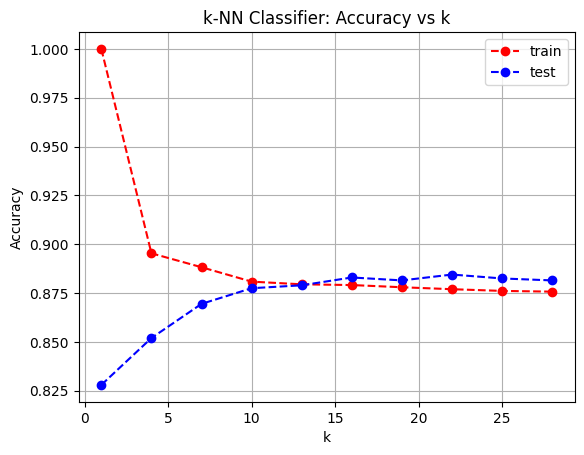

In [34]:
# k-NN Classifier con diversi valori di k
import numpy as np
k = np.arange(1,30,3)
score_train = []
score_test = []
j = 0

for i in k:
  n_neighbors = i
  clf = neighbors.KNeighborsClassifier(n_neighbors)
  clf.fit(X_train, y_train)
  score_train.append(clf.score(X_train, y_train))
  score_test.append(clf.score(X_test, y_test))
  print(f"k={i}\t\t train accuracy: {score_train[j]:.3f}\t\t test accuracy: {score_test[j]:.3f}")
  j+=1

plt.plot(k, score_train, marker='o', color='red', linestyle='--', label='train')
plt.plot(k, score_test, marker='o', color='blue', linestyle='--', label='test')
plt.legend()
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k-NN Classifier: Accuracy vs k')
plt.grid()
plt.plot()

**Commento sull'andamento delle accuracy**
- Per k piccolo si verifica un overfitting: il modello è sovradattato ai dati di train e non riesce a generalizzare sui dati di test.
- Per k crescente l'accuratezza sul train diminuisce e questo si traduce in una migliore generalizzazione, come si vede dall'accuracy sul test set che aumenta.
- Per k molto grande il modello potrebbe overfittare.

In [35]:
score_test = np.array(score_test)
max = score_test.max()
index = np.where(score_test==max)
k_best = k[index[0][0]]

print(f'Max test accuracy: {max} for k={k_best}')

Max test accuracy: 0.8845 for k=22


**Parte 4: Costruzione e allenamento di un modello di regressione di tipo k-NN**

L'algoritmo k-NN può essere utilizzato per predire un target continuo (regressione). In questo caso funziona stimando il target di una funzione y = f(x), come media dei k valori del campione di training più vicini (in accordo ad una predefinita distanza $d(x,x_i)$) al valore $x$:
> $\hat{y} = \hat{f}(x) = \frac{1}{k} \sum_{i\in k-nn(x)} y_i$. <p>

Compiti:

1.   addestrare un modello scikit-learn di tipo *neighbors.KNeighborsRegressor* per la task di predire il valore di Mjet a parire dalle altre 5 features (tau,C,D). Testare tre valori del parametro $k$:  $k=1,5,10, 20, 100$, e per oguno di essi printare il valore del coefficiente di determinazione $R^2$:

>```
># coefficiente di determinazione:
>```
>$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$:  
> ```
> in cui:
> ```
> $SS_{tot}$ = residui riespetto al valore medio del traget nei dati $(y-<y>) ^2$ (questa è la predizione più naive che si può pensare di fare) <p>
> $SS_{res}$ = residui rispetto alla predizione del modello $(y-pred)^2$ <p>
> ```
> assume valore 0 se il modello performa come un modello naive, 1 se il modello performa meglio del naive, e assume valori negativi se performa peggio del modello naive
>
>#ottenibile tramite il metodo .score(...) applicato al  modello KNeighborsRegressor
>```


NOTA: esempio di uso come regressore di k-NN disponibile nel sito di scikit-learn: [link](https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html#sphx-glr-auto-examples-neighbors-plot-regression-py)


2.   graficare i valori predetti per Mjet nel test set VS i valori veri

In [39]:
# divido le colonne separando Mjet dalle altre
target = col[0]
info = col[1:]

In [40]:
from sklearn import neighbors

pred_train = []
pred_test = []

n_neighbors = [1,5,10,20,100]
for i,n in enumerate(n_neighbors):
  clf = neighbors.KNeighborsRegressor(n)
  clf.fit(X_train[info], X_train[target])  # training
  score_test = clf.score(X_test[info], X_test[target])
  print(f'k={n}    R^2: {score_test:.3f}')
  pred_train.append(clf.predict(X_train[info]))
  pred_test.append(clf.predict(X_test[info]))

k=1    R^2: 0.891
k=5    R^2: 0.924
k=10    R^2: 0.923
k=20    R^2: 0.920
k=100    R^2: 0.872


In [41]:
pred_train = np.array(pred_train)
pred_test = np.array(pred_test)

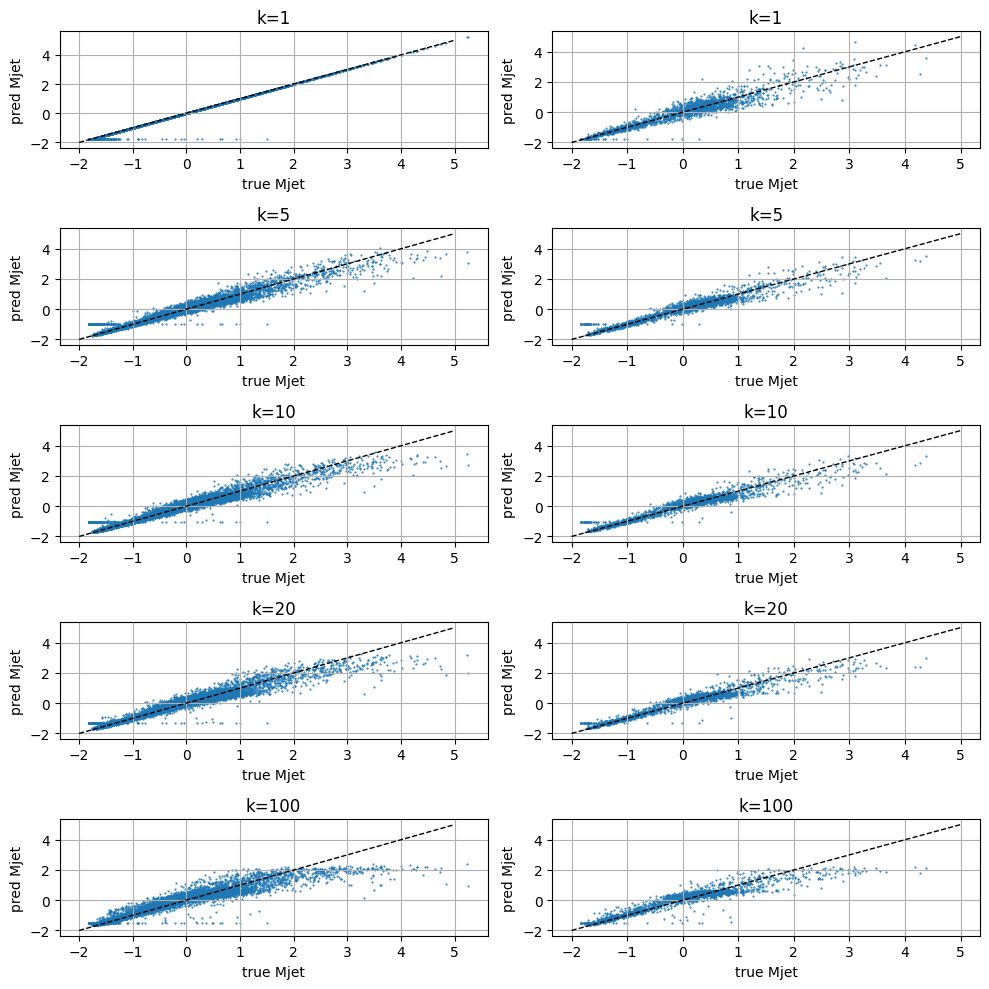

In [43]:
plt.figure(figsize=(10,10))

for i in range(len(pred_train)):
  plt.subplot(5,2,2*i+1)
  plt.title('k='+str(n_neighbors[i]))
  plt.scatter(X_train[target], pred_train[i], marker='.', s=1)
  plt.plot([-2,5],[-2,5], color='black', linewidth=1, linestyle='dashed')
  plt.xlabel('true Mjet')
  plt.ylabel('pred Mjet')
  plt.grid()
  plt.subplot(5,2,2*(i+1))
  plt.title('k='+str(n_neighbors[i]))
  plt.scatter(X_test[target], pred_test[i], marker='.', s=1)
  plt.plot([-2,5],[-2,5], color='black', linewidth=1, linestyle='dashed')
  plt.xlabel('true Mjet')
  plt.ylabel('pred Mjet')
  plt.grid()

plt.tight_layout()

**Esercizi suggeriti per casa:**

* provare a giocare con dimensione dei dataset, come scala il tempo di training del k-NN e del Naive-Bayes?
* ottimizzare $k$ nel training del classificatore k-NN, su cosa basereste la scelta ottimale? E nel caso del regressore?
* provate ad addestrare l'algoritmo di regressione eliminando alcune delle variabili, quali sono quelle più rilevanti? Perché?
* guardando alla documentazione dei diversi algoritmi su sklearn, provate a capire quali sono e come influiscono i parametri con cui si possono inizializzare gli algoritmi ...